In [1]:
import math
import time

import dill as pickle
import IPython.display as IPd
import matplotlib as mpl
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import torch
from matplotlib import ticker
from pyloric import create_prior, simulate, summary_stats
from pyloric.utils import energy_of_membrane, energy_of_synapse
from sbi.utils import ActiveSubspace

import stg_energy.fig3_active_subspaces.viz as viz
from stg_energy.fig3_active_subspaces.helper_functions import nth_argmax, nth_argmin

# Figure 3

In [2]:
pd.options.display.max_columns = 999

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
PANEL_A = "../svg/panel_a.svg"
PANEL_B = "../svg/panel_b.svg"
PANEL_C = "../svg/panel_c.svg"
PANEL_D = "../svg/panel_d.svg"
PANEL_E1 = "../svg/panel_e1.svg"
PANEL_E2 = "../svg/panel_e2.svg"
PANEL_F1 = "../svg/panel_f1.svg"
PANEL_F2 = "../svg/panel_f2.svg"
PANEL_G1 = "../svg/panel_g1.svg"
PANEL_G2 = "../svg/panel_g2.svg"
PANEL_H1 = "../svg/panel_h1.svg"
PANEL_H2 = "../svg/panel_h2.svg"
PANEL_I1 = "../svg/panel_i1.svg"
PANEL_I2 = "../svg/panel_i2.svg"

PANEL_supp_EV1 = "../svg/panel_supp_ev1.svg"
PANEL_supp_EV2 = "../svg/panel_supp_ev2.svg"
PANEL_supp_EV3 = "../svg/panel_supp_ev3.svg"

PANEL_supp_performance1 = "../svg/panel_supp_performance1.svg"
PANEL_supp_performance2 = "../svg/panel_supp_performance2.svg"
PANEL_supp_performance3 = "../svg/panel_supp_performance3.svg"

PANEL_supp_synapses1 = "../svg/panel_supp_synapses1.svg"
PANEL_supp_synapses2 = "../svg/panel_supp_synapses2.svg"
PANEL_supp_synapses3 = "../svg/panel_supp_synapses3.svg"

### Load experimental data

In [5]:
prior_11 = create_prior()

In [6]:
theta = pd.read_pickle(
    "../../../results/simulation_data_Tube_MLslurm_cluster/close_to_xo_circuit_parameters.pkl"
)
x = pd.read_pickle(
    "../../../results/simulation_data_Tube_MLslurm_cluster/close_to_xo_simulation_outputs.pkl"
)
seeds = np.load(
    "../../../results/simulation_data_Tube_MLslurm_cluster/close_to_xo_seeds.npy"
)

theta_np = theta.to_numpy()
x_np = x.to_numpy()

### Simulate the 55,000 samples and keep track of the energy consumption of each trace

In [7]:
def simulator(p_with_s):
    circuit_params = np.asarray([p_with_s[:-1]])
    theta_pd = pd.DataFrame(circuit_params, columns=theta.columns)
    out_target = simulate(
        theta_pd.loc[0], seed=int(p_with_s[-1]), track_energy=True, track_currents=True
    )
    all_energies = energy_of_membrane(out_target)
    synaptic_energies = energy_of_synapse(out_target)

    summed_energy_each_current = np.sum(all_energies, axis=2)
    summed_energy_synapses = np.sum(synaptic_energies, axis=1)
    summed_energy_total = np.sum(all_energies) + np.sum(synaptic_energies)
    fraction_of_each_current = summed_energy_each_current / summed_energy_total
    fraction_of_synapse = summed_energy_synapses / summed_energy_total
    return (fraction_of_each_current, fraction_of_synapse)

In [8]:
torch.manual_seed(0)
params_with_seeds = np.concatenate(
    (
        theta_np[:10],
        seeds[:10][
            None,
        ].T,
    ),
    axis=1,
)
simulation_outputs = list(map(simulator, params_with_seeds))

In [9]:
all_e_cur = []
all_e_syn = []
for so in simulation_outputs:
    e_cur, e_syn = so
    all_e_cur.append(e_cur)
    all_e_syn.append(e_syn)

all_e_cur = np.asarray(all_e_cur)
all_e_syn = np.asarray(all_e_syn)
fractions = np.mean(all_e_cur, axis=0)
synapse_fractions = np.mean(all_e_syn, axis=0)

In [10]:
current_fractions = fractions.T.flatten()
all_fractions = np.concatenate((current_fractions, synapse_fractions))
all_fractions /= np.linalg.norm(all_fractions)

### Sketch of active subspace

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


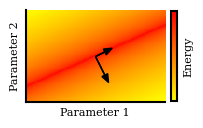

In [11]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.active_subspace_sketch()
    plt.savefig(PANEL_B, facecolor='None', transparent=False)

###  Fit regression net for total energy

In [12]:
with open(
    "../../../results/trained_neural_nets/inference/posterior_11deg.pickle", "rb"
) as handle:
    posterior = pickle.load(handle)

In [13]:
xo = np.load("../../../results/experimental_data/xo_11deg.npy")

In [14]:
energies = x["energies"]

In [62]:
energies_tt = torch.as_tensor(energies.to_numpy())
x_tt = torch.as_tensor(x_np, dtype=torch.float32)

In [63]:
num_test = 1000

theta_test = torch.as_tensor(theta_np[:num_test], dtype=torch.float32)
theta_train = torch.as_tensor(theta_np[num_test:], dtype=torch.float32)

In [64]:
train_energy = torch.as_tensor(
    torch.sum(energies_tt[num_test:], dim=1).unsqueeze(1), dtype=torch.float32
)
test_energy = torch.as_tensor(
    torch.sum(energies_tt[:num_test], dim=1).unsqueeze(1), dtype=torch.float32
)

In [65]:
torch.manual_seed(0)
sensitivity = ActiveSubspace(posterior.set_default_x(xo))
converged_nn = sensitivity.add_property(
    theta_train, train_energy, hidden_features=20, num_blocks=1
).train()
e_vals, e_vecs = sensitivity.find_active()

In [66]:
predictions = converged_nn(theta_test).detach()

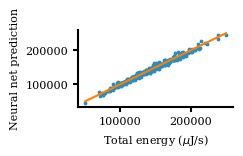

In [67]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(2, 1.0))
    unnorm_x = test_energy[:300]
    unnorm_y = predictions[:300]
    ax.scatter(x=unnorm_x.numpy(), y=unnorm_y.numpy(), s=3, color="#2b8cbe")
    gt_vec = np.linspace(np.min(unnorm_x.numpy()), np.max(unnorm_x.numpy()), 2)
    ax.plot(gt_vec, gt_vec, "#ff7f00")
    ax.set_xlabel("Total energy ($\mu$J/s)")
    ax.set_ylabel("Neural net prediction")
    plt.savefig(PANEL_supp_performance1, facecolor='None', transparent=False)

In [68]:
unnorm_y = predictions[:300]
mse = torch.mean(torch.abs(unnorm_x - unnorm_y) ** 2)
print("mean squared error: ", mse)

mean squared error:  tensor(23585780.)


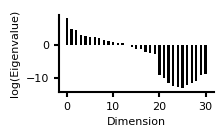

In [69]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.plot_eigenvalues(
        torch.log(torch.abs(torch.flip(e_vals, dims=(0,)))),
        figsize=(2.0, 1.0),
        color="k",
    )
    plt.savefig(PANEL_supp_EV1, facecolor="None", transparent=False)
    plt.show()

In [70]:
print("Ratio of first two eigenvalues:  ", e_vals[-1] / e_vals[-2])

Ratio of first two eigenvalues:   tensor(23.9573)


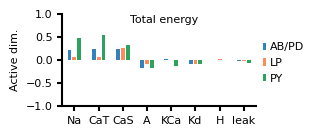

In [141]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.py_sensitivity_bars_cosyne(
        e_vecs[:, -1].T,
        ylim=[-1, 1.0],
        figsize=(2.5, 1.2),
        ylabel="Active dim.",
        plot_labels=True,
        title='Total energy',
    )
    plt.savefig(PANEL_C, facecolor="None", transparent=False)
    plt.show()

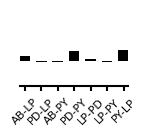

In [72]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.synapse_sensitivity_bars(
        e_vecs[24:, -1:].T, ylim=[-0.3, 0.6], figsize=(1.4, 1.0), ylabel="", color="k"
    )
    plt.savefig(PANEL_supp_synapses1, facecolor="None", transparent=False)
    plt.show()

## Which parameters affect energy, which parameters influence energy?

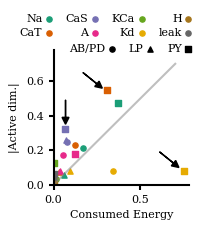

In [163]:
eigenvector = e_vecs[:, -1].numpy()

with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.scatter_sensitivity_consumption(all_fractions, eigenvector)
    plt.savefig(PANEL_D, facecolor="None", transparent=False)

# Energy per spike

In [89]:
all_energies_per_spike_ABPD = x["energies_per_spike"]["PM"].to_numpy()
all_energies_per_spike_ABPD_test = torch.as_tensor(
    all_energies_per_spike_ABPD[:num_test], dtype=torch.float32
).unsqueeze(1)
all_energies_per_spike_ABPD_train = torch.as_tensor(
    all_energies_per_spike_ABPD[num_test:], dtype=torch.float32
).unsqueeze(1)

In [90]:
torch.manual_seed(0)

sensitivity_e_per_spike = ActiveSubspace(posterior.set_default_x(xo))
converged_nn_e_per_spike = sensitivity_e_per_spike.add_property(
    theta_train, all_energies_per_spike_ABPD_train, hidden_features=20, num_blocks=1
).train()
predictions = converged_nn_e_per_spike(theta_test).detach().numpy()
e_vals_e_per_spike, e_vecs_e_per_spike = sensitivity_e_per_spike.find_active()

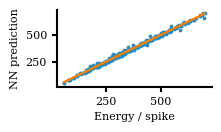

In [91]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(2, 1.0))
    unnorm_x = all_energies_per_spike_ABPD_test[:300].numpy()
    unnorm_y = predictions[:300]
    ax.scatter(x=unnorm_x, y=unnorm_y, s=3, color="#2b8cbe")
    gt_vec = np.linspace(np.min(unnorm_x), np.max(unnorm_x), 2)
    ax.plot(gt_vec, gt_vec, "#ff7f00")
    ax.set_xlabel("Energy / spike")
    ax.set_ylabel("NN prediction")
    plt.savefig(PANEL_supp_performance2, facecolor='None', transparent=False)

Ratio of first to second eigenvalue:  tensor(8.2767)


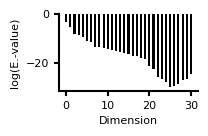

In [92]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.plot_eigenvalues(
        torch.log(torch.flip(torch.abs(e_vals_e_per_spike), dims=(0,))),
        figsize=(1.8, 1.0),
        ylabel="log(E.-value)",
        color="k",
    )
    print(
        "Ratio of first to second eigenvalue: ",
        e_vals_e_per_spike[-1] / e_vals_e_per_spike[-2],
    )
    plt.savefig(PANEL_supp_EV2, facecolor="None", transparent=False)
    plt.show()

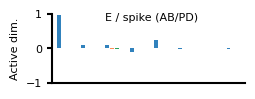

In [159]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.py_sensitivity_bars_cosyne(
        e_vecs_e_per_spike[:, -1].T,
        ylim=[-1, 1.0],
        figsize=(2.5, 0.9),
        ylabel="Active dim.",
        plot_labels=False,
        legend=False,
        title='E / spike (AB/PD)',
        title_x_offset=-0.6,
    )
    plt.savefig(PANEL_E1, facecolor="None", transparent=True)
    plt.show()

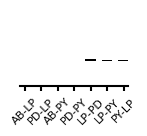

In [94]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.synapse_sensitivity_bars(
        e_vecs_e_per_spike[24:, -1:].T, ylim=[-0.3, 0.6], figsize=(1.4, 1.0), ylabel="", color="k"
    )
    plt.savefig(PANEL_supp_synapses2, facecolor="None", transparent=False)
    plt.show()

## Number of spikes

In [95]:
numSpikesPerBurst = x["num_spikes"]["PM"].to_numpy() / x["num_bursts"]["PM"].to_numpy()
numSpikesPerBurst_test = torch.as_tensor(
    numSpikesPerBurst[:num_test], dtype=torch.float32
).unsqueeze(1)
numSpikesPerBurst_train = torch.as_tensor(
    numSpikesPerBurst[num_test:], dtype=torch.float32
).unsqueeze(1)

In [96]:
torch.manual_seed(0)

sensitivity_num_spikes = ActiveSubspace(posterior.set_default_x(xo))
converged_nn_num_spikes = sensitivity_num_spikes.add_property(
    theta_train,
    numSpikesPerBurst_train,
    hidden_features=20,
    num_blocks=1
).train()
e_vals_num_spikes, e_vecs_num_spikes = sensitivity_num_spikes.find_active()

In [97]:
predictions = converged_nn_num_spikes(theta_test).detach().numpy()

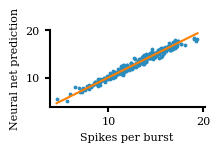

In [98]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(2, 1.0))
    unnorm_x = numSpikesPerBurst_test[:300].numpy()
    unnorm_y = predictions[:300]
    ax.scatter(x=unnorm_x, y=unnorm_y, s=3, color="#2b8cbe")
    gt_vec = np.linspace(np.min(unnorm_x), np.max(unnorm_x), 2)
    ax.plot(gt_vec, gt_vec, "#ff7f00")
    ax.set_xlabel("Spikes per burst")
    ax.set_ylabel("Neural net prediction")
    plt.savefig(PANEL_supp_performance3, facecolor='None', transparent=False)

Ratio of first to second eigenvalue:  tensor(24.2971)


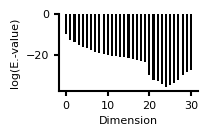

In [99]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.plot_eigenvalues(
        torch.log(torch.flip(torch.abs(e_vals_num_spikes), dims=(0,))),
        figsize=(1.8, 1.0),
        ylabel="log(E.-value)",
        color="k",
    )
    print(
        "Ratio of first to second eigenvalue: ",
        e_vals_num_spikes[-1] / e_vals_num_spikes[-2],
    )
    plt.savefig(PANEL_supp_EV3, facecolor="None", transparent=False)
    plt.show()

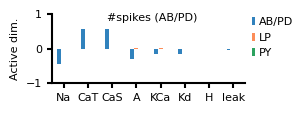

In [171]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.py_sensitivity_bars_cosyne(
        e_vecs_num_spikes[:, -1].T,
        ylim=[-1, 1.0],
        figsize=(2.5, 0.9),
        ylabel="Active dim.",
        plot_labels=True,
        legend = True,
        legend_y_offset = 0.3,
        title='#spikes (AB/PD)',
        title_x_offset=-0.5,
    )
    plt.savefig(PANEL_E2, facecolor="None", transparent=True)
    plt.show()

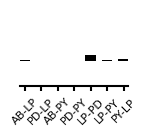

In [101]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.synapse_sensitivity_bars(
        e_vecs_num_spikes[24:, -1:].T, ylim=[-0.3, 0.6], figsize=(1.4, 1.0), ylabel="", color="k"
    )
    plt.savefig(PANEL_supp_synapses3, facecolor="None", transparent=False)
    plt.show()

# Relationship between the two

In [213]:
projected_e_per_spike = sensitivity_e_per_spike.project(theta_train, num_dimensions=1)
projected_num_spikes = sensitivity_num_spikes.project(theta_train, num_dimensions=1)

In [289]:
ind_of_min_e_per_spike = nth_argmin(projected_e_per_spike, 0)
ind_of_max_e_per_spike = nth_argmax(projected_e_per_spike, 27)

ind_of_min_numSpikes = nth_argmin(projected_num_spikes, 1)
ind_of_max_numSpikes = nth_argmax(projected_num_spikes, 0)

In [359]:
cond1 = projected_e_per_spike > -1.0
cond2 = projected_e_per_spike < -0.8
cond3 = projected_num_spikes > -0.7
cond4 = projected_num_spikes < -0.6

In [360]:
full_cond = torch.logical_and(
    torch.logical_and(torch.logical_and(cond1, cond2), cond3), cond4
)

In [361]:
fulfiling_param_sets = theta_train[full_cond[:, 0]]
print(fulfiling_param_sets.shape)

torch.Size([10, 31])


In [362]:
parameter_set1 = theta_train[ind_of_min_e_per_spike].unsqueeze(0)
parameter_set1_dim1 = sensitivity_e_per_spike.project(parameter_set1, num_dimensions=1)
parameter_set1_dim2 = sensitivity_num_spikes.project(parameter_set1, num_dimensions=1)

parameter_set2 = theta_train[ind_of_min_numSpikes].unsqueeze(0)
parameter_set2_dim1 = sensitivity_e_per_spike.project(parameter_set2, num_dimensions=1)
parameter_set2_dim2 = sensitivity_num_spikes.project(parameter_set2, num_dimensions=1)

# parameter_set3 = train_params_norm[ind_of_max_e_per_spike].unsqueeze(0)
parameter_set3 = theta_train[full_cond[:, 0]][2].unsqueeze(0)
parameter_set3_dim1 = sensitivity_e_per_spike.project(parameter_set3, num_dimensions=1)
parameter_set3_dim2 = sensitivity_num_spikes.project(parameter_set3, num_dimensions=1)

In [363]:
energy_PM = x["energies"]["PM"].to_numpy()
energy_PM_train = energy_PM[num_test:]

In [364]:
v1 = e_vecs_num_spikes[:, -1]
v2 = e_vecs_e_per_spike[:, -1]
norm_v1 = torch.norm(v1)
dot_prod = torch.dot(v1, v2).item()
angle = math.acos(dot_prod)
print("angle in rad:", angle)
print("angle in deg:", angle / 2 / math.pi * 360)

angle_within_90deg = math.pi - angle
my_ticker = ticker.FixedFormatter([-2, 0, 2])

angle in rad: 1.921349484561041
angle in deg: 110.08521643498378


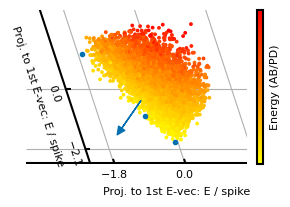

In [403]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig = plt.figure(figsize=(3.1, 2.0))
    viz.curvelinear_test1(
        fig,
        angle_within_90deg,
        projected_num_spikes,
        projected_e_per_spike,
        energy_PM_train,
        parameter_set1_dim1,
        parameter_set1_dim2,
        parameter_set2_dim1,
        parameter_set2_dim2,
        parameter_set3_dim1,
        parameter_set3_dim2,
    )
    plt.savefig(PANEL_F1, facecolor="None", transparent=True)
    plt.show()

### Run simulations

In [428]:
all_energies_per_spike = x["energies_per_spike"]["PM"].to_numpy()
all_energies = x["energies"]["PM"].to_numpy()
all_num_spikes = x["num_spikes"]["PM"].to_numpy()

min_energy_per_spike = np.min(all_energies_per_spike)
max_energy_per_spike = np.max(all_energies_per_spike)

min_energy = np.min(all_energies)
max_energy = np.max(all_energies)

min_num_spikes = np.min(all_num_spikes)
max_num_spikes = np.max(all_num_spikes)

In [429]:
unnorm_set_dim_1 = pd.DataFrame(parameter_set1[:1], columns=theta.columns)
unnorm_set_dim_2 = pd.DataFrame(parameter_set2[:1], columns=theta.columns)
unnorm_set_dim_3 = pd.DataFrame(parameter_set3[:1], columns=theta.columns)

simulation_output_1 = simulate(
    unnorm_set_dim_1.loc[0], seed=0, track_energy=True, track_currents=True
)
simulation_output_2 = simulate(
    unnorm_set_dim_2.loc[0], seed=0, track_energy=True, track_currents=True
)
simulation_output_3 = simulate(
    unnorm_set_dim_3.loc[0], seed=0, track_energy=True, track_currents=True
)

In [430]:
time_vec = np.arange(0, 11000, 0.025)

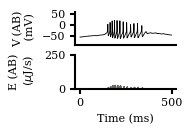

In [477]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.energy_scape(
        simulation_output_1,
        time_vec,
        (1.3, 1.0),
        ["k", "k", "k"],
        time_len=20000,
        offset=103000,
        ylimE=[0, 250],
        v_labelpad=4.7,
        neuron=0,
    )
    plt.savefig(PANEL_G1, facecolor="None", transparent=True)

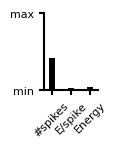

In [478]:
summstats = summary_stats(
    simulation_output_1,
    stats_customization={
        "energies": True,
        "num_spikes": True,
        "energies_per_spike": True,
    },
)
num_spikes_ABPD = summstats["num_spikes"]["PM"].to_numpy()[0]
energies_ABPD_sim = summstats["energies"]["PM"].to_numpy()[0]
energyperspike_ABPD_sim = summstats["energies_per_spike"]["PM"].to_numpy()[0]

with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.bars_for_energy(
        num_spikes_ABPD,
        min_num_spikes,
        max_num_spikes,
        energyperspike_ABPD_sim,
        min_energy_per_spike,
        max_energy_per_spike,
        energies_ABPD_sim,
        min_energy,
        max_energy,
    )
    plt.savefig(PANEL_G2, facecolor="None", transparent=True)
    plt.show()

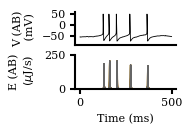

In [479]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.energy_scape(
        simulation_output_2,
        time_vec,
        (1.3, 1.0),
        ["k", "k", "k"],
        time_len=20000,
        offset=255000,
        ylimE=[0, 250],
        v_labelpad=4.7,
        neuron=0,
    )
    plt.savefig(PANEL_H1, facecolor="None", transparent=True)

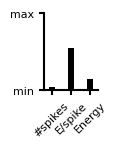

In [480]:
summstats = summary_stats(
    simulation_output_2,
    stats_customization={
        "energies": True,
        "num_spikes": True,
        "energies_per_spike": True,
    },
)
num_spikes_ABPD = summstats["num_spikes"]["PM"].to_numpy()[0]
energies_ABPD_sim = summstats["energies"]["PM"].to_numpy()[0]
energyperspike_ABPD_sim = summstats["energies_per_spike"]["PM"].to_numpy()[0]

with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.bars_for_energy(
        num_spikes_ABPD,
        min_num_spikes,
        max_num_spikes,
        energyperspike_ABPD_sim,
        min_energy_per_spike,
        max_energy_per_spike,
        energies_ABPD_sim,
        min_energy,
        max_energy,
    )
    plt.savefig(PANEL_H2, facecolor="None", transparent=True)
    plt.show()

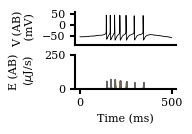

In [481]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.energy_scape(
        simulation_output_3,
        time_vec,
        (1.3, 1.0),
        ["k", "k", "k"],
        time_len=20000,
        offset=300000,
        ylimE=[0, 250],
        v_labelpad=4.7,
        neuron=0,
    )
    plt.savefig(PANEL_I1, facecolor="None", transparent=True)

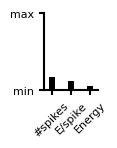

In [482]:
summstats = summary_stats(
    simulation_output_3,
    stats_customization={
        "energies": True,
        "num_spikes": True,
        "energies_per_spike": True,
    },
)
num_spikes_ABPD = summstats["num_spikes"]["PM"].to_numpy()[0]
energies_ABPD_sim = summstats["energies"]["PM"].to_numpy()[0]
energyperspike_ABPD_sim = summstats["energies_per_spike"]["PM"].to_numpy()[0]

with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.bars_for_energy(
        num_spikes_ABPD,
        min_num_spikes,
        max_num_spikes,
        energyperspike_ABPD_sim,
        min_energy_per_spike,
        max_energy_per_spike,
        energies_ABPD_sim,
        min_energy,
        max_energy,
    )
    plt.savefig(PANEL_I2, facecolor="None", transparent=True)
    plt.show()

## Assemble figure

In [483]:
time_vec = np.arange(0, 11000, 0.025)

In [484]:
def svg(img):
    IPd.display(IPd.HTML('<img src="{}" / >'.format(img, time.time())))

In [485]:
from svgutils.compose import *

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise
factor_svg=5.5

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_text_12pt = {'size': '12pt', 'font': 'Arial', 'weight': '500'}
kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}
kwargs_text8pt_blue = {'size': '7.7pt', 'font': 'Arial', 'weight': '500', 'color': "#0570b0"}

f = Figure("20.3cm", "13.0cm",

    Panel(
          SVG(PANEL_A).scale(svg_scale).move(0, 0*factor_svg),
        Text("a", -5.0*factor_svg, -4.5*factor_svg, **kwargs_text),
    ).move(5*factor_svg, 7*factor_svg),

    Panel(
          SVG(PANEL_B).scale(svg_scale).move(0, 0*factor_svg),
          Text("b", -2.0*factor_svg, 2.5*factor_svg, **kwargs_text),
          Text("inactive", 15.0*factor_svg, 7.0*factor_svg, **kwargs_text8pt),
          Text("active", 11.0*factor_svg, 13.5*factor_svg, **kwargs_text8pt),
    ).move(45*factor_svg, 0*factor_svg),
    Panel(
          SVG(PANEL_C).scale(svg_scale).move(0, 0*factor_svg),
          Text("c", -2.0*factor_svg, 2.5*factor_svg, **kwargs_text),
    ).move(89*factor_svg, 0*factor_svg),

    Panel(
          SVG(PANEL_D).scale(svg_scale).move(0, 0*factor_svg),
          Text("d", -3*factor_svg, 2.5*factor_svg, **kwargs_text),
    ).move(3.0*factor_svg, 25.0*factor_svg),

    Panel(
          SVG(PANEL_E1).scale(svg_scale).move(0, 0*factor_svg),
          Text("e", -1*factor_svg, 1.5*factor_svg, **kwargs_text),
    ).move(44.0*factor_svg, 26.0*factor_svg),

    Panel(
          SVG(PANEL_E2).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
    ).move(44*factor_svg, 41.5*factor_svg),

    Panel(
          SVG(PANEL_F1).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
        Text("g", 11.1*factor_svg, 9.9*factor_svg, **kwargs_text8pt_blue),
        Text("h", 26.5*factor_svg, 24.7*factor_svg, **kwargs_text8pt_blue),
        Text("i", 22.0*factor_svg, 20.5*factor_svg, **kwargs_text8pt_blue),
        Text("f", -2.0*factor_svg, -1.1*factor_svg, **kwargs_text),
    ).move(92*factor_svg, 28.6*factor_svg),

    Panel(
          SVG(PANEL_F2).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
    ).move(92*factor_svg, 50.7*factor_svg),

    Panel(
          SVG(PANEL_G1).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
        Text("g", -2.0*factor_svg, 2.5*factor_svg, **kwargs_text),
    ).move(2*factor_svg, 150+40.0*factor_svg),

    Panel(
          SVG(PANEL_G2).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
    ).move(29*factor_svg, 150+39.5*factor_svg),

    Panel(
          SVG(PANEL_H1).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
        Text("h", -2.0*factor_svg, 2.5*factor_svg, **kwargs_text),
    ).move(48*factor_svg, 150+40*factor_svg),

    Panel(
          SVG(PANEL_H2).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
    ).move(75*factor_svg, 150+39.5*factor_svg),

    Panel(
          SVG(PANEL_I1).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
        Text("i", -2.0*factor_svg, 2.5*factor_svg, **kwargs_text),
    ).move(94*factor_svg, 150+40*factor_svg),

    Panel(
          SVG(PANEL_I2).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
    ).move(121*factor_svg, 150+39.5*factor_svg),
)

!mkdir -p fig
f.save("../fig/fig3_active_subspace.svg")
svg('../fig/fig3_active_subspace.svg')

### Build appendix

In [137]:
from svgutils.compose import *

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise
factor_svg=5.5

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_text_12pt = {'size': '12pt', 'font': 'Arial', 'weight': '500'}
kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}
kwargs_text8pt_red = {'size': '7.7pt', 'font': 'Arial', 'weight': '800', 'color': "#b30000"}

f = Figure("20.3cm", "3.2cm",

    Panel(
          SVG(PANEL_supp_EV1).scale(svg_scale).move(0, 0*factor_svg),
    ).move(0*factor_svg, 0*factor_svg),
           
    Panel(
          SVG(PANEL_supp_EV2).scale(svg_scale).move(0, 0*factor_svg),
    ).move(40*factor_svg, 0*factor_svg),
           
    Panel(
          SVG(PANEL_supp_EV3).scale(svg_scale).move(0, 0*factor_svg),
    ).move(80*factor_svg, 0*factor_svg),
)

!mkdir -p fig
f.save("../fig/fig3_supp_EV_spectrum.svg")
svg('../fig/fig3_supp_EV_spectrum.svg')

In [150]:
from svgutils.compose import *

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise
factor_svg=5.5

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_text_12pt = {'size': '12pt', 'font': 'Arial', 'weight': '500'}
kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}
kwargs_text8pt_red = {'size': '7.7pt', 'font': 'Arial', 'weight': '800', 'color': "#b30000"}

f = Figure("20.3cm", "4.0cm",

    Panel(
          SVG(PANEL_supp_performance1).scale(svg_scale).move(0, 0*factor_svg),
    ).move(0*factor_svg, 0*factor_svg),
           
    Panel(
          SVG(PANEL_supp_performance2).scale(svg_scale).move(0, 0*factor_svg),
    ).move(40*factor_svg, 0*factor_svg),
           
    Panel(
          SVG(PANEL_supp_performance3).scale(svg_scale).move(0, 0*factor_svg),
    ).move(80*factor_svg, 0*factor_svg),
)

!mkdir -p fig
f.save("../fig/fig3_reg_supp_performance.svg")
svg('../fig/fig3_reg_supp_performance.svg')

In [156]:
from svgutils.compose import *

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise
factor_svg=5.5

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_text_12pt = {'size': '12pt', 'font': 'Arial', 'weight': '500'}
kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}
kwargs_text8pt_red = {'size': '7.7pt', 'font': 'Arial', 'weight': '800', 'color': "#b30000"}

f = Figure("20.3cm", "3.0cm",

    Panel(
          SVG(PANEL_supp_synapses1).scale(svg_scale).move(0, 0*factor_svg),
    ).move(0*factor_svg, 0*factor_svg),
           
    Panel(
          SVG(PANEL_supp_synapses2).scale(svg_scale).move(0, 0*factor_svg),
    ).move(25*factor_svg, 0*factor_svg),
           
    Panel(
          SVG(PANEL_supp_synapses3).scale(svg_scale).move(0, 0*factor_svg),
    ).move(50*factor_svg, 0*factor_svg),
)

!mkdir -p fig
f.save("../fig/fig3_reg_supp_synapses.svg")
svg('../fig/fig3_reg_supp_synapses.svg')